<a href="https://colab.research.google.com/github/pure-water/462deferred/blob/master/GPUvsTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why TPUs ?

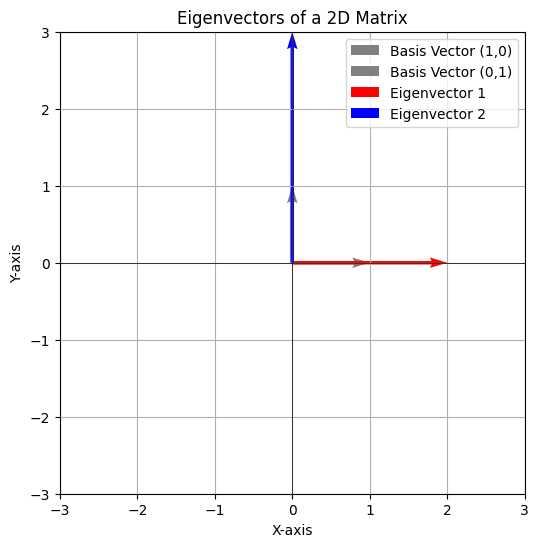

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define a 2x2 matrix (modify this for experiments)
A = np.array([[2, 0],
              [0, 3]])

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(A)

# Define the original basis vectors for reference
basis_vectors = np.array([[1, 0], [0, 1]])

# Plot settings
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the original basis vectors
ax.quiver(0, 0, basis_vectors[0, 0], basis_vectors[1, 0], color='gray', angles='xy', scale_units='xy', scale=1, label='Basis Vector (1,0)')
ax.quiver(0, 0, basis_vectors[0, 1], basis_vectors[1, 1], color='gray', angles='xy', scale_units='xy', scale=1, label='Basis Vector (0,1)')

# Plot the eigenvectors
for i in range(2):
    vec = eigenvectors[:, i] * eigenvalues[i]  # Scale for visualization
    ax.quiver(0, 0, vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color='r' if i == 0 else 'b', label=f'Eigenvector {i+1}')

# Grid and settings
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Eigenvectors of a 2D Matrix')
ax.grid()
ax.legend()

# Show the plot
plt.show()


TPUs are tensor processing units developed by Google to  accelerate operations on a Tensorflow Graph. Each TPU packs up to 180 teraflops of floating-point performance and 64 GB of high-bandwidth memory onto a single board. Here is a comparions between TPUs and Nvidia GPUs. The y axis represents # images per seconds and the x axis is different models.

<img src="https://cdn-images-1.medium.com/max/800/1*tVHGjJHJrhKaKECT3Z4CIw.png" alt="Drawing" style="width: 150px;"/>

# Experiement

TPUs were only available on Google cloud but now they are available for free in Colab. We will be comparing TPU vs GPU here on colab using mnist dataset. We will compare the time of each step and epoch against different batch sizes.

# Downoad MNIST

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.utils import to_categorical

def get_data():

  #Load mnist data set
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255

  x_train = np.expand_dims(x_train, 3)
  x_test = np.expand_dims(x_test, 3)

  y_train = to_categorical(y_train)
  y_test  = to_categorical(y_test)

  return x_train, y_train, x_test, y_test

# Basic CNN

Note that since we need to run the code on TPU we need to do more work. We need to specify the address of the TPU and tell tensorflow to run the model on the TPU cluster

In [ ]:
from tensorflow.contrib.tpu.python.tpu import keras_support

def get_model(tpu = False):
  model = tf.keras.Sequential()

  #add layers to the model
  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  #compile the model
  model.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

  #flag to run on tpu
  if tpu:
    tpu_grpc_url = "grpc://"+os.environ["COLAB_TPU_ADDR"]

    #connect the TPU cluster using the address
    tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_grpc_url)

    #run the model on different clusters
    strategy = keras_support.TPUDistributionStrategy(tpu_cluster_resolver)

    #convert the model to run on tpu
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)
  return model

#GPU vs TPU


In [ ]:
x_train, y_train, x_test, y_test = get_data()

Each time you want to run the model on TPU make sure to set the tpu flag and change the enviornment runtime via  Edit> Notebook Setting > Hardware Accelerator > TPU and then click save.

In [ ]:
#set tpu = True if you want to run the model on TPU
model = get_model(tpu = False)

In [ ]:
model.fit(x_train,
         y_train,
         batch_size=1024,
         epochs=10,
         validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 2s 38us/step - loss: 0.1639 - acc: 0.9513 - val_loss: 0.0677 - val_acc: 0.9752
Epoch 2/3
60000/60000 [==============================] - 2s 35us/step - loss: 0.1345 - acc: 0.9573 - val_loss: 0.0552 - val_acc: 0.9808
Epoch 3/3
60000/60000 [==============================] - 2s 40us/step - loss: 0.1189 - acc: 0.9619 - val_loss: 0.0443 - val_acc: 0.9848


# Benchmarks

Note that TPU setup takes some time when compiling the model and distributing the data in the clusters, so the first epoch will take alonger time. I only reported the time for the later epochs. I calculated the average time accross different epochs.

### Epoch Time ($s$)

$$\left[\begin{array}{c|c|c}  
 \textbf{Batch Size} & \textbf{GPU} & \textbf{TPU} \\
 256 & 6s & 6s\\  
 512 & 5s & 3s\\
 1024 & 4s & 2s\\
\end{array}\right]$$

### Step Time ($\mu s$)

$$\left[\begin{array}{c|c|c}  
 \textbf{Batch Size} & \textbf{GPU} & \textbf{TPU} \\
 256 & 94 \mu s & 97 \mu s\\  
 512 & 82 \mu  s& 58 \mu s \\
 1024 & 79 \mu s & 37 \mu s\\
\end{array}\right]$$

# References



*   https://qiita.com/koshian2/items/25a6341c035e8a260a01
*   https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a
*   https://blog.riseml.com/benchmarking-googles-new-tpuv2-121c03b71384
*   https://cloudplatform.googleblog.com/2018/02/Cloud-TPU-machine-learning-accelerators-now-available-in-beta.html

